<a href="https://colab.research.google.com/github/Frostofree/CVIT_Worskshop/blob/main/MachineLearningBasics/CNNTut.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [14]:
import torch
import torchvision
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor
import torch.optim as optim

## Downloading Datasets
Using the CIFAR10 Dataset with the classes - 
 ‘airplane’, ‘automobile’, ‘bird’, ‘cat’, ‘deer’, ‘dog’, ‘frog’, ‘horse’, ‘ship’, ‘truck’.

60000 32x32 colour images , 6000 images in every class. 
50000 training images and 10000 testing images


PIL images of range [0,1] 
We wish to convert them into Tensors of Normalized range [-1,1]

In [15]:
# Downloading Train Dataset

training_data = datasets.CIFAR10(
    root = "./data",
    train=True,
    download=True,
    transform=torchvision.transforms.Compose(                  # Chain Transforms together with Compose
        [ToTensor(),
         torchvision.transforms.Normalize((0.5,0.5,0.5), (0.5,0.5,0.5))]      # Normalizes with mean = 0.5 and std = 0.5
    )
)

# Downloading Test Dataset
testing_data = datasets.CIFAR10(
    root = "./data",
    train=False,
    download=True,
    transform=torchvision.transforms.Compose(                  # Chain Transforms together with Compose
        [ToTensor(),
         torchvision.transforms.Normalize((0.5,0.5,0.5), (0.5,0.5,0.5))]      # Normalizes with mean = 0.5 and std = 0.5
    )
)

Files already downloaded and verified
Files already downloaded and verified


Loading Datasets into PyTorch's Dataloader

In [16]:
# Batch Size 
batch_size = 4

train_dataloader = DataLoader(training_data,batch_size=batch_size, num_workers=2)     # Workers are number of subprocesses to use for data loading
test_dataloader = DataLoader(testing_data,batch_size=batch_size,num_workers=2)


classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')


### Visualising some of the training images

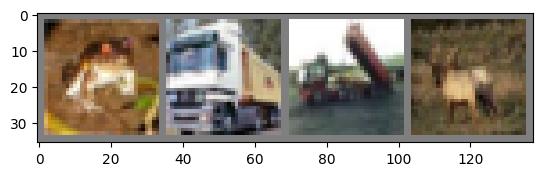

frog  truck truck deer 


In [17]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(train_dataloader)
images, labels = next(dataiter)

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))


## Defining a CNN
This CNN will have 2 Convolution layerss with a MAx Pooling Layer in between,followed by 2 FC layers and 1 Softmax layer.



In [22]:
class CNN(nn.Module):
  def __init__(self):
    super().__init__()
    self.conv1 = nn.Conv2d(3,6,5)       # No. of in channels = 3, No. of out channels = 6 and Kernel size is 5
    self.pool = nn.MaxPool2d(2,2)       # Kernel size = 2 , stride = 2
    self.conv2 = nn.Conv2d(6,16,5)      # Stride = 1 By default
    self.fc1 = nn.Linear(16*5*5,120)    # No. of outchannels * (??)
    self.fc2 = nn.Linear(120,84)
    self.fc3 = nn.Linear(84,10)         # Softmax

  def forward(self,x):
    x = self.pool(nn.functional.relu(self.conv1(x)))
    x = self.pool(nn.functional.relu(self.conv2(x)))
    x = torch.flatten(x,1)                 # Shapes into 1D tensor
    x = nn.functional.relu(self.fc1(x))
    x = nn.functional.relu(self.fc2(x))
    x = self.fc3(x)
    return x

net = CNN()


## Define Loss Function and Optimiser

Momentum is an extension to GD optimisation that allows the seach to build inertia in a direction in the search space and overcome oscillations of noisy gradients and coast across flat spots of the search space.
Reduces number of Oscillations
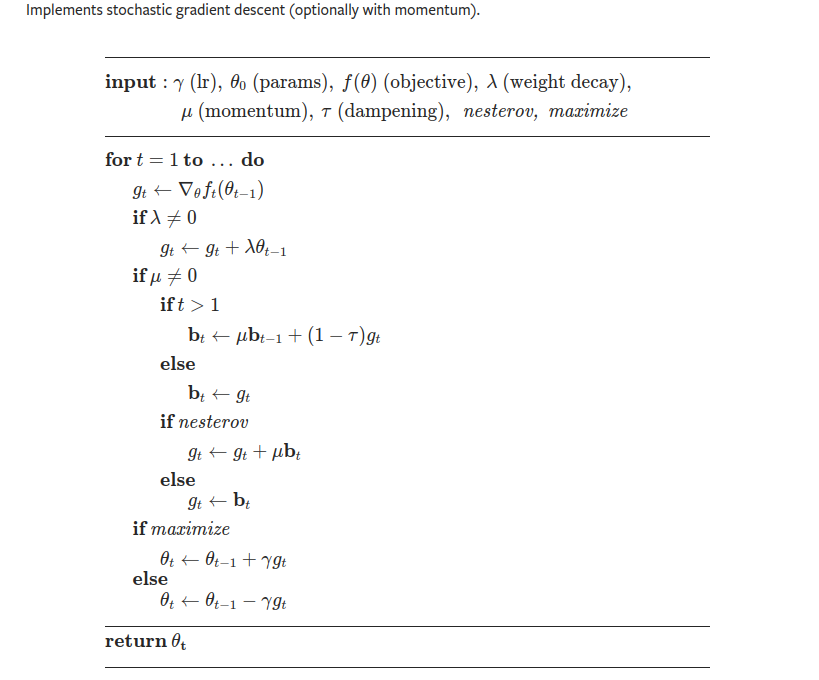

In [31]:
loss_fn = nn.CrossEntropyLoss()
optimiser = optim.SGD(net.parameters(),lr=0.005,momentum=0.5)     

## lr = 0.005 and momentum = 0.5 produced accuracy 45%

## Training Network


In [32]:
epochs = 2

for epoch in range(epochs):
  running_loss = 0.0
  for i, data in enumerate(train_dataloader, 0):
    # Get inputs, and labels
    inputs, labels = data

    # Zero the parameter gradients
    optimiser.zero_grad()

    # Forward
    outputs = net(inputs)
    # Backward
    loss = loss_fn(outputs,labels)
    loss.backward()
    # Optimise
    optimiser.step()  

    running_loss += loss.item()
    if i % 2000 == 1999:    # print every 2000 mini-batches
        print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}')
        running_loss = 0.0

print("Trainin Khatam")


[1,  2000] loss: 1.786
[1,  4000] loss: 1.729
[1,  6000] loss: 1.655
[1,  8000] loss: 1.598
[1, 10000] loss: 1.600
[1, 12000] loss: 1.592
[2,  2000] loss: 1.549
[2,  4000] loss: 1.539
[2,  6000] loss: 1.508
[2,  8000] loss: 1.470
[2, 10000] loss: 1.501
[2, 12000] loss: 1.487
Trainin Khatam


## Testing


In [33]:
_, predicted = torch.max(outputs, 1)

correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in test_dataloader:
        images, labels = data
        # calculate outputs by running images through the network
        outputs = net(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the 10000 test images: {100 * correct // total} %')

Accuracy of the network on the 10000 test images: 45 %


Our model Presently can correctly classify items a little less than 50% of the time

Let's see which classes it failed miserably


In [34]:
# prepare to count predictions for each class
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

# again no gradients needed
with torch.no_grad():
    for data in test_dataloader:
        images, labels = data
        outputs = net(images)
        _, predictions = torch.max(outputs, 1)
        # collect the correct predictions for each class
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1


# print accuracy for each class
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print(f'Accuracy for class: {classname:5s} is {accuracy:.1f} %')

Accuracy for class: plane is 33.8 %
Accuracy for class: car   is 68.3 %
Accuracy for class: bird  is 26.8 %
Accuracy for class: cat   is 35.2 %
Accuracy for class: deer  is 31.1 %
Accuracy for class: dog   is 38.2 %
Accuracy for class: frog  is 55.6 %
Accuracy for class: horse is 58.6 %
Accuracy for class: ship  is 69.0 %
Accuracy for class: truck is 42.3 %
